In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Computed Mean: 0.00047873196177541135, Std: 0.04881513040647449
Data Augmented
Model Created
Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0000
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0000
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 21, Loss: 0.0000
Epoch 22, Loss: 0.0000
Epoch 23, Loss: 0.0000
Epoch 24, Loss: 0.0000
Epoch 25, Loss: 0.0000
Epoch 26, Loss: 0.0000
Epoch 27, Loss: 0.0000
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Training Finished


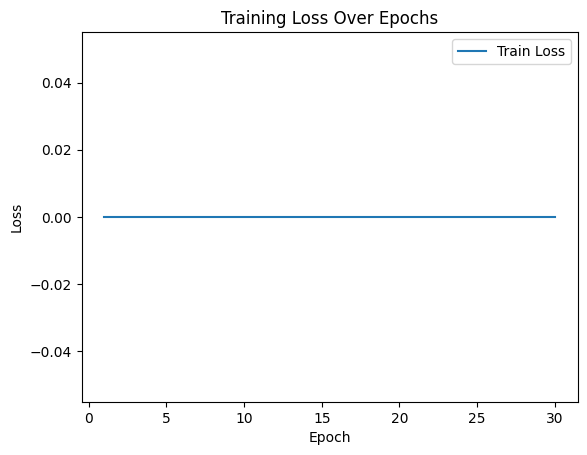

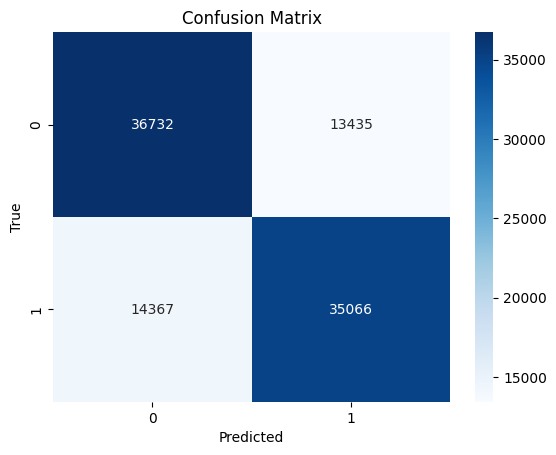

Accuracy: 72.09%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torch.optim.lr_scheduler import CosineAnnealingLR

def cutmix_data(x, y, alpha=1.0):
    ''' Applies CutMix augmentation '''
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0))
    y_shuffled = y[rand_index]
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    
    return x, y, y_shuffled, lam

def mixup_data(x, y, alpha=1.0):
    ''' Applies MixUp augmentation '''
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0))
    
    mixed_x = lam * x + (1 - lam) * x[rand_index]
    y_shuffled = y[rand_index]
    
    return mixed_x, y, y_shuffled, lam

def rand_bbox(size, lam):
    '''Generates a random rectangular bounding box'''
    W = size[2]
    H = size[3]
    cut_w = int(W * np.sqrt(1 - lam))
    cut_h = int(H * np.sqrt(1 - lam))
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    return bbx1, bby1, bbx2, bby2

# Custom Dataset Class
class ParticleDataset(Dataset):
    def __init__(self, hdf5_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        
        for idx, file in enumerate(hdf5_files):
            with h5py.File(file, 'r') as f:
                X = f['X'][:]
                y = np.full((X.shape[0],), idx)  # Assign label 0 for electrons, 1 for photons
                self.data.append(X)
                self.labels.append(y)
        
        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Load Dataset
full_dataset = ParticleDataset(['/kaggle/input/cms-particle-collison/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 
                                '/kaggle/input/cms-particle-collison/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'])

# Split into Train and Test  # *MODIFIED*
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Compute Mean and Std for Normalization on Train Set  # *MODIFIED*
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size
        images = images.view(batch_samples, -1)
        mean += images.mean(dim=1).sum().item()
        std += images.std(dim=1).sum().item()
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

mean, std = compute_mean_std(train_dataset)  # *MODIFIED*
print(f"Computed Mean: {mean}, Std: {std}")

# Define Data Augmentation and Normalization  # *MODIFIED*
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Normalize((mean,), (std,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reload dataset with transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Augmented")

# Define ResNet-like Model
# class ResNet15(nn.Module):
#     def _init_(self):
#         super(ResNet15, self)._init_()
#         self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.res_layers = self._make_res_layers(64, 128, 4)
#         # Compute final feature map size dynamically
#         with torch.no_grad():
#             dummy_input = torch.randn(1, 2, 32, 32)
#             dummy_output = self.res_layers(self.relu(self.bn1(self.conv1(dummy_input))))
#             final_h, final_w = dummy_output.shape[2], dummy_output.shape[3]
        
#         self.fc = nn.Linear(128 * final_h * final_w, 2)
    
#     def _make_res_layers(self, in_channels, out_channels, blocks):
#         layers = []
#         for _ in range(blocks):
#             layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
#             layers.append(nn.BatchNorm2d(out_channels))
#             layers.append(nn.ReLU(inplace=True))
#             in_channels = out_channels
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.res_layers(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.fc(x)
#         return x
# class ResidualBlock(nn.Module):
#     def _init_(self, in_channels, out_channels, downsample=False):
#         super(ResidualBlock, self)._init_()
#         stride = 2 if downsample else 1  # Downsample only if specified
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         # Identity shortcut connection
#         self.shortcut = nn.Sequential()
#         if downsample or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         identity = self.shortcut(x)
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out += identity  # Skip connection
#         out = self.relu(out)
#         return out
class SEBlock(nn.Module):
    ''' Squeeze-and-Excitation Block '''
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = x.mean((2, 3))  # Global Average Pooling
        y = self.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y))
        y = y.view(batch, channels, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)  # Add SE block

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Apply SE block
        out += identity
        out = self.relu(out)
        return out
        
class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual Blocks with Skip Connections
        self.layer1 = self._make_res_layers(64, 64, blocks=2, downsample=False)
        self.layer2 = self._make_res_layers(64, 128, blocks=2, downsample=True)
        self.layer3 = self._make_res_layers(128, 256, blocks=2, downsample=True)
        self.layer4 = self._make_res_layers(256, 512, blocks=2, downsample=True)

        # Compute final feature map size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 2, 32, 32)  # Dummy input to infer shape
            dummy_output = self._forward_features(dummy_input)
            final_h, final_w = dummy_output.shape[2], dummy_output.shape[3]

        self.fc = nn.Linear(512 * final_h * final_w, num_classes)

    def _make_res_layers(self, in_channels, out_channels, blocks, downsample):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, downsample=False))
        return nn.Sequential(*layers)

    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet15().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=40)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# model.load_state_dict(torch.load("/kaggle/input/epoch30/pytorch/default/1/resnet15_weights.pth"))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
print("Model Created")

# Training Loop
num_epochs = 30
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        if np.random.rand() < 0.5:
            images, labels_a, labels_b, lam = cutmix_data(images, labels)
        else:
            images, labels_a, labels_b, lam = mixup_data(images, labels)
            
        images = images.to(device)
        labels_a = labels_a.to(device)
        labels_b = labels_b.to(device)
        
        outputs = model(images)
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

print("Training Finished")

# Plot Training Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true):.2f}%')



torch.save(model.state_dict(), "resnet15_like_weights.pth")